In [1]:
import geopandas as gpd
gdf = gpd.read_file('../data/xenium/stardist_all.geojson')

In [49]:

gdf3 = gpd.read_file('../data/xenium/voronoi_tresholded_buffered.geojson')

In [41]:
import geopandas as gpd
from scipy.spatial import Voronoi
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mpl_polygon

gdf['centroid'] = gdf.geometry.centroid
centroids = np.array([(geom.x, geom.y) for geom in gdf['centroid']])
vor = Voronoi(centroids)


In [33]:
import numpy as np
from shapely.geometry import Polygon, Point

# Step 1: Ensure centroids are Shapely Points
centroids = gdf['centroid'].apply(lambda x: Point(x.x, x.y)).tolist()

# Step 3: Convert Voronoi regions to Shapely polygons
def voronoi_to_polygons(vor, centroids):
    polygons = []
    for region_idx, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if not -1 in vertices and len(vertices) > 0:
            polygon = Polygon([vor.vertices[i] for i in vertices])
            # Ensure the polygon contains the corresponding centroid
            if polygon.contains(centroids[region_idx]):
                polygons.append(polygon)
    return polygons

# Create polygons from the Voronoi tessellation
vor_polygons = voronoi_to_polygons(vor, centroids)

# Step 4: Convert Voronoi polygons to a GeoDataFrame
vor_gdf = gpd.GeoDataFrame(geometry=vor_polygons)


In [17]:
vor_gdf.to_file('../data/xenium/voronoi.geojson', driver='GeoJSON')

In [5]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

# Print the image shape
print("Image shape:", img.shape)

/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_56147/218545800.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')


Image shape: (24241, 30786, 3)


Cropped image shape: (2500, 1000, 3)


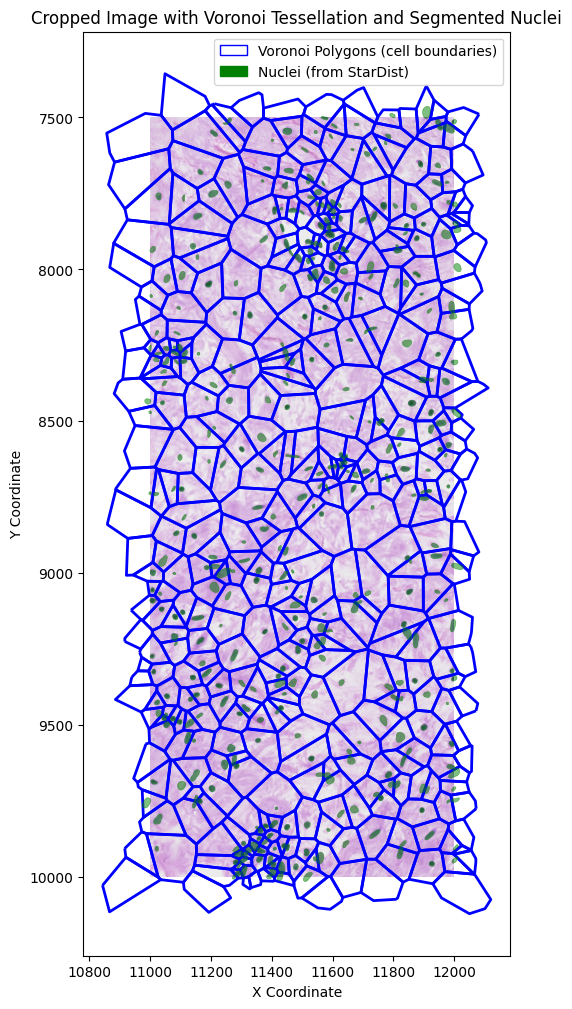

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from shapely.geometry import box

# Define bounding box
bbox = (11000, 7500, 12000, 10000)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Create a Polygon for the bounding box
bbox_polygon = box(*bbox)
gdf.crs = None

# Filter both GeoDataFrames to only include polygons within the bounding box
gdf_bbox_filtered = vor_gdf[vor_gdf.intersects(bbox_polygon)]
gdf_filtered = gdf[gdf.intersects(bbox_polygon)]

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image with the original coordinate extent
ax.imshow(cropped_img, origin='upper', extent=[bbox[0], bbox[2], bbox[3], bbox[1]])

# Plot the Voronoi tessellation polygons from the filtered GeoDataFrame
gdf_bbox_filtered.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot the nuclei from the original GeoDataFrame, also filtered by the bounding box
gdf_filtered.plot(ax=ax, edgecolor='green', facecolor='green', linewidth=0.5, alpha=0.5)

# Optionally, add a legend
legend_elements = [
    Patch(edgecolor='blue', facecolor='none', label='Voronoi Polygons (cell boundaries)'),
    Patch(edgecolor='green', facecolor='green', label='Nuclei (from StarDist)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation and Segmented Nuclei')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


In [42]:
max_diameter_microns = 30 
mpp = 0.2125
max_radius_pixels = (max_diameter_microns / 2) / mpp
max_radius_pixels

70.58823529411765

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

# Create the Voronoi diagram
vor_thresholded = Voronoi(centroids)

# Define a maximum radius (threshold)
max_radius = max_radius_pixels

# Function to limit polygon size
def limit_polygon_size(vor, point_index, max_radius):
    region_index = vor.point_region[point_index]
    vertices = vor.regions[region_index]
    if -1 in vertices:  # Ignore infinite regions
        return None
    
    polygon = Polygon([vor.vertices[i] for i in vertices])
    centroid = Point(vor.points[point_index])
    
    # Check distance to the farthest vertex
    max_distance = max(centroid.distance(Point(v)) for v in polygon.exterior.coords)
    
    if max_distance > max_radius:
        return centroid.buffer(max_radius).intersection(polygon)
    else:
        return polygon

# Create polygons and limit their size
limited_polygons = []
for i in range(len(centroids)):
    limited_polygon = limit_polygon_size(vor, i, max_radius)
    if limited_polygon:
        limited_polygons.append(limited_polygon)




In [44]:
vor_gdf2 = gpd.GeoDataFrame(geometry=limited_polygons)

Cropped image shape: (1000, 1000, 3)


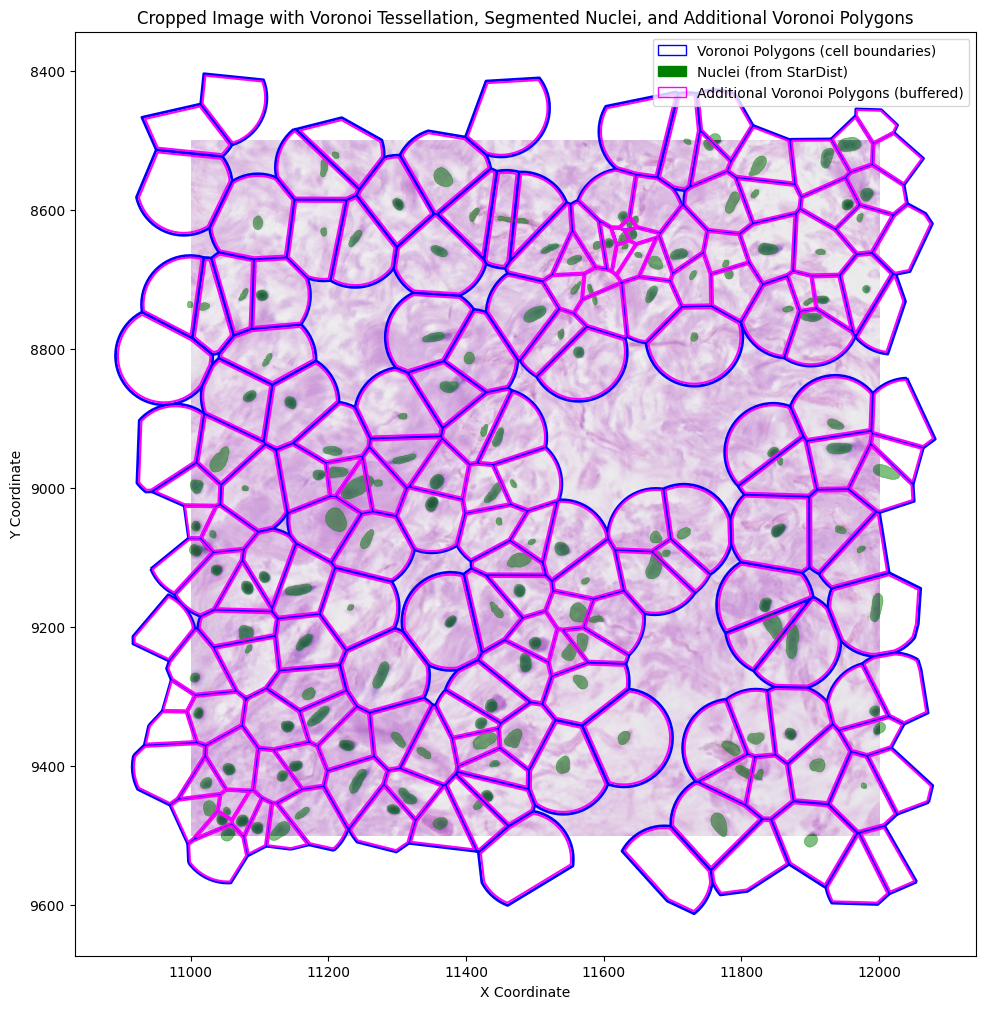

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from shapely.geometry import box

# Define bounding box
bbox = (11000, 8500, 12000, 9500)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using the adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Create a Polygon for the bounding box
bbox_polygon = box(*bbox)
gdf.crs = None

# Filter both GeoDataFrames to only include polygons within the bounding box
gdf_bbox_filtered = vor_gdf2[vor_gdf2.intersects(bbox_polygon)]
gdf_filtered = gdf[gdf.intersects(bbox_polygon)]
gdf_bbox_filtered2 = gdf3[gdf3.intersects(bbox_polygon)]  # For the new vor_gdf2

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image with the original coordinate extent
ax.imshow(cropped_img, origin='upper', extent=[bbox[0], bbox[2], bbox[3], bbox[1]])

# Plot the Voronoi tessellation polygons from the filtered GeoDataFrame
gdf_bbox_filtered.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot the nuclei from the original GeoDataFrame, also filtered by the bounding box
gdf_filtered.plot(ax=ax, edgecolor='green', facecolor='green', linewidth=0.5, alpha=0.5)

# Plot the additional Voronoi tessellation polygons from vor_gdf2 in yellow
gdf_bbox_filtered2.plot(ax=ax, edgecolor='magenta', facecolor='none', linewidth=1.5)

# Optionally, add a legend
legend_elements = [
    Patch(edgecolor='blue', facecolor='none', label='Voronoi Polygons (cell boundaries)'),
    Patch(edgecolor='green', facecolor='green', label='Nuclei (from StarDist)'),
    Patch(edgecolor='magenta', facecolor='none', label='Additional Voronoi Polygons (buffered)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation, Segmented Nuclei, and Additional Voronoi Polygons')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


In [47]:
vor_gdf.to_file('../data/xenium/voronoi.geojson', driver='GeoJSON')

In [48]:
vor_gdf2.to_file('../data/xenium/voronoi_thresholded.geojson', driver='GeoJSON')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from shapely.geometry import box

# Define bounding box
bbox = (11000, 8500, 12000, 9500)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using the adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Create a Polygon for the bounding box
bbox_polygon = box(*bbox)
gdf.crs = None

# Filter both GeoDataFrames to only include polygons within the bounding box
gdf_bbox_filtered = vor_gdf[vor_gdf.intersects(bbox_polygon)]
gdf_filtered = gdf[gdf.intersects(bbox_polygon)]
gdf_bbox_filtered2 = vor_gdf2[vor_gdf2.intersects(bbox_polygon)]  # For the new vor_gdf2

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image with the original coordinate extent
ax.imshow(cropped_img, origin='upper', extent=[bbox[0], bbox[2], bbox[3], bbox[1]])

# Plot the Voronoi tessellation polygons from the filtered GeoDataFrame
gdf_bbox_filtered.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot the nuclei from the original GeoDataFrame, also filtered by the bounding box
gdf_filtered.plot(ax=ax, edgecolor='green', facecolor='green', linewidth=0.5, alpha=0.5)

# Plot the additional Voronoi tessellation polygons from vor_gdf2 in yellow
gdf_bbox_filtered2.plot(ax=ax, edgecolor='magenta', facecolor='none', linewidth=1.5)

# Optionally, add a legend
legend_elements = [
    Patch(edgecolor='blue', facecolor='none', label='Voronoi Polygons (cell boundaries)'),
    Patch(edgecolor='green', facecolor='green', label='Nuclei (from StarDist)'),
    Patch(edgecolor='magenta', facecolor='none', label='Additional Voronoi Polygons (from vor_gdf2)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation, Segmented Nuclei, and Additional Voronoi Polygons')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()
